## Least Square Method

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

In [2]:
# Loading data contained in a csv file.

data = pd.read_csv('SambnisImp.csv')

# Filtering of the initial table to keep only the 91 useful variables.
data_filtred = data[["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

# Display of the first lines of the filtered table
data_filtred.head()

,warstds,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,...,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,0,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,...,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,0,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,...,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,0,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,...,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,0,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,...,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


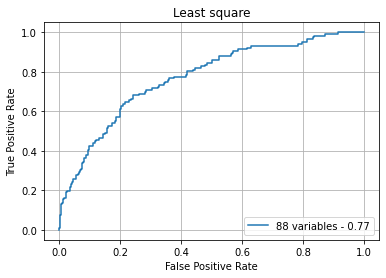

In [3]:
model = linear_model.LinearRegression()
graph_title = "Least square"

X = data_filtred
X = X.drop('warstds',axis=1)
y = data['warstds']

# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model, X, y, cv=10)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:])

# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

# Stores the ROC curve plot for each model.
plt.plot(fpr, tpr, label="88 variables" + " - {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Drawing ROC curves with the legend
plt.legend(loc='lower right')
# Adding the title according to the selected regression type
plt.title(graph_title)
plt.grid()
plt.show()